### LEARNING TO FINETUNE TORCHVISION OBJECT DETECTION MODELS

#### ABSTRACT
- Pytorch에서 object detection과 segmentation의 분야에서 특히나 vgg-16, resnet-101등의 사전에 훈련된 모델들을 이용하고 fine-tuning을 진행해서 해당 역할을 수행하곤 한다.

- 따라서 모델을 직접 수정해서 사용하는 방법을 연습해 vgg-16에 적용해 최종적으로 Deep Net을 만들어 볼 예정이다.

#### 1. Defining the Dataset
- Dataset을 새롭게 custom해서 만들기 위해서는 custom해서 ```torch.utils.data.Dataset```클래스를 이용하고 __len__, __getitem__을 사용해야 한다.
- image : PIL Image of size (H, W)
- target : a dict containing the following fields
  1. boxes : label for each bounding box
  2. image_id : image identifier
  3. area : area of the bounding box
  4. iscrowd : Evaluation 단계에서 무시될/고려하지 않을 데이터

- 새롭게 만드는 모델이 위와 같은 method를 반환한다면 training과 evaluation이 모두 가능하게 될 것이다.

- 학습 중에 batch가 비슷한 크기를 지닌 것으로 묶이도록 하고 싶다면 ```get_height_and_width```메서드를 사용해서 이미지의 높이와 가로 길이를 반환하도록 하는 것이 추천된다.
- label = 0이 배경인데, 새롭게 만든 dataset가 class중에 배경이 없다면 label에 0이 없어야 한다.

#### 2. Writing a Custom Dataset for PennFundan
- 파일을 직접 다운받아서 압축하기가 번거로울 것 같아서 우선 url을 이용해서 다운을 받기로 했다.

In [3]:
import re
import urllib.request as request
import codecs

# url 저장 경로 지정
url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
# 파일명
name = "PennFundan.zip"
# 다운로드
response = request.urlretrieve(url, name)
print('Download Complete')


Download Complete


In [4]:
import zipfile
import os
# extractall()을 이용해서 현재 저장소에 zip파일의 압축을 풀어서 저장mport zipfile
import os
# extractall()을 이용해서 현재 저장소에 zip파일의 압축을 풀어서 저장
PennFundan = zipfile.ZipFile('PennFundan.zip').extractall()
PennFundan = zipfile.ZipFile('PennFundan.zip').extractall()

In [5]:
import os
import numpy as np
import torch
from PIL import Image

class PennFundanDataset(object):
  def __init__(self, root, transform):
    self.root = root
    self.transform = transform
    self.imgs = [sorted(os.listdir(os.path.join(root, "PNGImages")))]
    self.masks = [sorted(os.listdir(os.path.joiin(root, "PedMasks")))]
  
  def __getitem__(self, idx):
    # load images ad masks
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.imgs[idx])
    img = Image.open(img_path).convert("RGB")
    # masking된 데이터에 대해서는 RGB로 바꾸면 안된다
    # 각각의 데이터가 다른 영역을 나타내는 색이기 때문이다.
    mask = Image.open(mask_path)
    # PIL Image를 numpy array로 바꾸어 준다.
    mask = np.array(mask)
    # 각각의 영역은 다른 색으로 구성이 되어 있다.
    obj_ids = np.unique(mask)
    # 첫번째 id는 배경이기 때문에 제거한다.
    obj_idx = obj_ids[1:]

    # 색깔로 칠해진 mask를 set의 형태로 바꾸어 준다.
    masks = mask == obj_ids[:, None, None]

    # 모든 mask에 대해서 bounding box를 얻는다.
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      # numpy의 where()함수를 이용해서 순서대로 mask 별로 index를 반환받는다.
      pos = np.where(masks[i])
      xmin, xmax = np.min(pos[1]), np.max(pos[1])
      ymin, ymax = np.min(pos[1]), np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])
    
    boxes = torch.as_tensor(boxes, dtype = torch.float32)
    labels = torch.ones((num_objs,), dtype = torch.int64)
    masks = torch.as_tensor(masks, dtype = torch.uint8)

    image_id = torch.tensor([idx])
    # box의 수치가 [왼쪽위, 왼쪽아래, 오른쪽위, 오른쪽아래] 
    # area = (가로길이) * (세로길이)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype = torch.int64)

    # 실제로 Fast R-CNN에 사용된 데이터의 set에 속해 있는 얻어질 수 있는 정보들의 목록을 그대로 구현
    # box, label, mask, image_id, area, target
    # 기존의 모델을 사용하기 위해서는 dataset까지 그대로 만들어서(새로운 데이터를 이용해 학습하고자 한다면)
    # 적용해야 한다.
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)
    
    return img, target

  def __len__(self):
    return len(self.imgs)

#### 3. Defining The Model
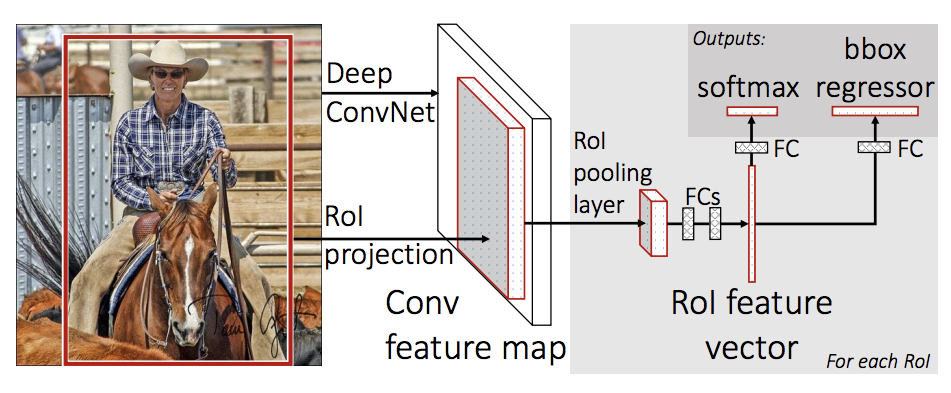

- torchvision에 있는 모델들을 modify해서 전이 학습을 진행하기 위해 수행할 수 있는 두가지 방법이 존재한다.
  1. 이미 학습된 모델을 이용해서 마지막 층만 finetune을 진행한다.
  2. 더 빠른 학습을 위해서 model중간의 backbone, 즉 설계를 수정하는 것이 맞다.

#### 3-1. Finetuning From a Pretrained Model

In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

# 분류 가능한 class의 개수를 20개에서 2개로 줄여서 출력하는 model을 설계한다.
num_classes = 2 # (person + background)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


#### 3-2. Modifying the Model to Add a Different Backbone
- 아래 코드에서 models.detection.rpn을 불러오는데, 이는 Region Proposal Network이다.
- 먼저 Feature Map을 추출한 뒤에 이를 RPN에 전달하여 RoI를 계산을 하는 것이 바로 Faster R-CNN의 핵심 구조이다.

** RPN의 구조**
1. CNN을 통해 뽑아낸 feature map을 입력으로 받는다. 
2. Feature map에 3x3 convolution layer을 256, 또는 512개의 channel 만큼 수행하도록 한다. (padding = 1로 설정하여서 가로와 세로 크기가 보존이 될 수 있도록 한다.)

- 기본적으로 FasterRCNN은 정의가 되어 있다.
- 따라서 ```model = FasterRCNN(backbone, num_classes, image_mean, image_std, ..., *kwargs)```와 같이 ()안에 argument를 입력해 주면 사용자가 맞게 조절이 가능한 것이다.
- FasterRCNN의 경우에는 input 값으로 [C, H, W]크기의 tensor을 입력밧게 되거, 이미지는 다양한 크기여도 되지만 pixel 값들이 FasterRCNN의 경우에는 input 값으로 [C, H, W]크기의 tensor을 입력밧게 되거, 이미지는 다양한 크기여도 되지만 pixel 값들이 0에서 1사이의 값에 해당 되어야 한다.
- 학습 하는 중에 model은 input tensor 뿐만 아니라 target값들도 사전형 데이터의 형태로 입력 받도록 해야 한다.
- 아래와 같은 방법으로 계속 모델의 원본 SOURCE CODE에서 입력되어야 할 argument값을 확인하면서 필요한 값들을 넣어주면 된다.
- backbone이란 classification을 위해서 적용이 되는 사전 훈련된 모델을 의미한다.

```
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
backbone = torchvision.models.mobilenet_v2(pretrained = True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(
            sizes = ((32, 64, 128, 256, 512),),
            aspect_ratios = ((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
  featmap_names = ['0'], output_size = 7, sampling_ratio = 2)
model = FasterRCNN(backbone, 
                    num_classes = 2,
                    rpn_anchor_generator = anchor_generator,
                    box_roi_pool = roi_pooler)                    
                    
```
class FasterRCNN(GeneralizedRCNN):
  def __init__(self, backbone, num_classes=None,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # RPN parameters
                 rpn_anchor_generator=None, rpn_head=None,
                 rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 rpn_score_thresh=0.0,
                 # Box parameters
                 box_roi_pool=None, box_head=None, box_predictor=None,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None):

        if not hasattr(backbone, "out_channels"):
            raise ValueError(
                "backbone should contain an attribute out_channels "
                "specifying the number of output channels (assumed to be the "
                "same for all the levels)")

        assert isinstance(rpn_anchor_generator, (AnchorGenerator, type(None)))
        assert isinstance(box_roi_pool, (MultiScaleRoIAlign, type(None)))

        if num_classes is not None:
            if box_predictor is not None:
                raise ValueError("num_classes should be None when box_predictor is specified")
        else:
            if box_predictor is None:
                raise ValueError("num_classes should not be None when box_predictor "
                                 "is not specified")

        out_channels = backbone.out_channels

        if rpn_anchor_generator is None:
            anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
            aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
            rpn_anchor_generator = AnchorGenerator(
                anchor_sizes, aspect_ratios
            )
        if rpn_head is None:
            rpn_head = RPNHead(
                out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
            )

        rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
        rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)

        rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh,
            score_thresh=rpn_score_thresh)

        if box_roi_pool is None:
            box_roi_pool = MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=7,
                sampling_ratio=2)

        if box_head is None:
            resolution = box_roi_pool.output_size[0]
            representation_size = 1024
            box_head = TwoMLPHead(
                out_channels * resolution ** 2,
                representation_size)

        if box_predictor is None:
            representation_size = 1024
            box_predictor = FastRCNNPredictor(
                representation_size,
                num_classes)

        roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)

        if image_mean is None:
            image_mean = [0.485, 0.456, 0.406]
        if image_std is None:
            image_std = [0.229, 0.224, 0.225]
        transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std)

        super(FasterRCNN, self).__init__(backbone, rpn, roi_heads, transform)
```

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

#  classification을 위해서 사전 학습된 모델을 다운받는다.
# mobilenet_v2를 classification, 즉 class분류를 위한 모델로 입력하고자 한다.
backbone = torchvision.models.mobilenet_v2(pretrained = True).features
# backbone structure이 출력 channel의 개수를 알아야 하는데
# mobilenet_v2의 경우에는 1280이다.
backbone.out_channels = 1280

# RPN이 각 면적마다 5x3크기의 데이터를 읽을 수 있도록 한다.
anchor_generator = AnchorGenerator(
    sizes = ((32, 64, 128, 256, 512),),
    aspect_ratios = ((0.5, 1.0, 2.0),)
)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names = [0], output_size = 7, sampling_ratio = 2
)

# 모든 backbone의 수정된 사항들을 FasterRCNN model에 넣는다.
model = FasterRCNN(
    backbone, num_classes = 2,
    rpn_anchor_generator = anchor_generator,
    box_roi_pool = roi_pooler
)




#### 4. An Instance Segmentation Model for PennFundan Dataset

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
  # 우선 COCO dataset에 의해 학습이 된 segmentation model을 불러온다.
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                     hidden_layer, num_classes
                                                     )
  return model

In [ ]:
import transforms as T

def get_transform(train):
  transforms = []
  transforms.append(T.ToTensor())
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5),
                      T.CenterCrop(10), T.ToTensor)
  # Compose() class는 다수의 transform메서드를 뭉쳐서 내보내 준다.
  return T.Compose(transforms)

#### 5. Testing ```forward()``` method

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
# 위에서 정의한 transform시키는 함수를 이용했다.
dataset = PennFundanDataset('PennFundanPed', get_transform(train = True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size = 2, shuffle = True, num_workers = 4,
    collate_fn = utils.collate_fn
)

images, targets = next(iter(data_loader))
images = [image for image in images]
targets = [{k:v for k,v in t.items()} for t in targets] 
# output에는 loss와 detection결과가 담겨 있다.
output = model(images, targets) 
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [ ]:
from engine import train_one_epoch, evaluate
import utils

def main():
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  num_classes = 2
  dataset = PennFundanDataset('PennFundanPed', get_transform(train = True))
  dataset_test = PennFundanDataset('PennFundanPed', get_transform(train = False))

  indices = torch.randperm(len(dataset)).tolist()
  dataset = torch.utils.data.Subset(dataset, indices[:-50])
  dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

  data_loader = torch.utils.data.DataLoader(
      dataset, batch_size = 2, shuffle = True, num_workers = 4,
      collate_fn = utils.collate_fn
  )

  data_loader_test = torch.utils.data.DataLoader(
      dataset, batch_size = 1, shuffle = True, num_workers = 4,
      collate_fn = utils.collate_fn
  )

  model = get_model_instance_segmentation(num_classes)
  model.to(device)
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr = 0.005, 
                              momentum = 0.9, weight_decay = 0.0005)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                 step_size = 3, gamma = 0.1)
  num_epochs = 10
  for i in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq = 10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device = device)
  print("The End of Training!")



- Torch Vision의 SOURCE정보에 들어가보면 DeepLab V3가 코드화 되어있음을 알 수 있다.
- pytorch에서 사용하는 segmentation에 적용되는 모델의 backbone은 **resnet** 시리즈나 **mobilenet** 시리즈가 이용이 된다.
- 

In [2]:
# a module wrapper that returns intermediate layers from a model
from torchvision.models._utils import IntermediateLayerGetter
# model을 다운받을 수 있는 url의 저장소로부터 모델의 상태를 dictionary의 형태로 반환해주는 함수이다.
from torchvision.models.utils import load_state_dict_from_url
# torchvision의 models모듈로부터
# mobilenetv3, resnet, DeepLabHead, DeepLabV3, FCN(Fully Connected Network), FCNHead, LRASPP
# 위와 같은 모델들을 다운받는다.
from torchvision.models import mobilenetv3
from torchvision.models import resnet
from torchvision.models.segmentation.deeplabv3 import DeepLabHead, DeepLabV3
from torchvision.models.segmentation.fcn import FCN, FCNHead
from torchvision.models.segmentation.lraspp import LRASPP

In [ ]:
def _segm_model(name, backbone_name, num_classes, aux, pretrained_backbone=True):
    if 'resnet' in backbone_name:
        backbone = resnet.__dict__[backbone_name](
            pretrained=pretrained_backbone,
            replace_stride_with_dilation=[False, True, True])
        out_layer = 'layer4'
        out_inplanes = 2048
        aux_layer = 'layer3'
        aux_inplanes = 1024
    elif 'mobilenet_v3' in backbone_name:
        backbone = mobilenetv3.__dict__[backbone_name](pretrained=pretrained_backbone, _dilated=True).features

        # Gather the indices of blocks which are strided. These are the locations of C1, ..., Cn-1 blocks.
        # The first and last blocks are always included because they are the C0 (conv1) and Cn.
        stage_indices = [0] + [i for i, b in enumerate(backbone) if getattr(b, "_is_cn", False)] + [len(backbone) - 1]
        out_pos = stage_indices[-1]  # use C5 which has output_stride = 16
        out_layer = str(out_pos)
        out_inplanes = backbone[out_pos].out_channels
        aux_pos = stage_indices[-4]  # use C2 here which has output_stride = 8
        aux_layer = str(aux_pos)
        aux_inplanes = backbone[aux_pos].out_channels
    else:
        raise NotImplementedError('backbone {} is not supported as of now'.format(backbone_name))

    return_layers = {out_layer: 'out'}
    if aux:
        return_layers[aux_layer] = 'aux'
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    aux_classifier = None
    if aux:
        aux_classifier = FCNHead(aux_inplanes, num_classes)

    model_map = {
        'deeplabv3': (DeepLabHead, DeepLabV3),
        'fcn': (FCNHead, FCN),
    }
    classifier = model_map[name][0](out_inplanes, num_classes)
    base_model = model_map[name][1]

    model = base_model(backbone, classifier, aux_classifier)
    return model


def _load_model(arch_type, backbone, pretrained, progress, num_classes, aux_loss, **kwargs):
    if pretrained:
        aux_loss = True
        kwargs["pretrained_backbone"] = False
    model = _segm_model(arch_type, backbone, num_classes, aux_loss, **kwargs)
    if pretrained:
        _load_weights(model, arch_type, backbone, progress)
    return model


def _load_weights(model, arch_type, backbone, progress):
    arch = arch_type + '_' + backbone + '_coco'
    model_url = model_urls.get(arch, None)
    if model_url is None:
        raise NotImplementedError('pretrained {} is not supported as of now'.format(arch))
    else:
        state_dict = load_state_dict_from_url(model_url, progress=progress)
        model.load_state_dict(state_dict)


def _segm_lraspp_mobilenetv3(backbone_name, num_classes, pretrained_backbone=True):
    backbone = mobilenetv3.__dict__[backbone_name](pretrained=pretrained_backbone, _dilated=True).features

    # Gather the indices of blocks which are strided. These are the locations of C1, ..., Cn-1 blocks.
    # The first and last blocks are always included because they are the C0 (conv1) and Cn.
    stage_indices = [0] + [i for i, b in enumerate(backbone) if getattr(b, "_is_cn", False)] + [len(backbone) - 1]
    low_pos = stage_indices[-4]  # use C2 here which has output_stride = 8
    high_pos = stage_indices[-1]  # use C5 which has output_stride = 16
    low_channels = backbone[low_pos].out_channels
    high_channels = backbone[high_pos].out_channels

    backbone = IntermediateLayerGetter(backbone, return_layers={str(low_pos): 'low', str(high_pos): 'high'})

    model = LRASPP(backbone, low_channels, high_channels, num_classes)
    return model